In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
pd.set_option('display.max_rows', 1000) 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import warnings
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
warnings.filterwarnings("ignore")

In [4]:
sperm_data = pd.read_csv(r"all_features.csv")
sperm_data = sperm_data.replace("-", np.nan)
sperm_data = sperm_data.dropna()
blas_rate = sperm_data["BLAST_D8"].copy()
blas_rate = pd.to_numeric(blas_rate)
sperm_data = sperm_data.drop(columns=['BLAST_D8'])

In [5]:
correlated_features = set()
correlation_matrix = sperm_data.corr()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
sperm_data.drop(labels=correlated_features, axis=1, inplace=True)
sperm_data = sperm_data.apply(pd.to_numeric)

In [6]:
# FIVE DATASETS TO TEST ON
# - all non-correlated features
# - ss_cells
# - ss_motility
# - ss_pct
# - pca (done on training set, then applied on testing)
ss_cells = sperm_data[["AI", "PI", "ALTO", "FRAG_CRO"]].copy()
ss_motility = sperm_data[["VAP", "VCL", "ALH", "BCF", "STR"]].copy()
ss_pct = sperm_data[["MOTILE_PCT", "MEDIUM_PCT", "SLOW_PCT", "STATIC_PCT"]].copy()

In [20]:
def accuracy(correct, predicted, classes):
    accuracy=[]
    elements = []
    for label in classes:
        accuracy.append(100*np.mean([(x == y)  for x, y in zip(correct,predicted) if x==label]))  
        elements.append(len([(x == y)  for x, y in zip(correct,predicted) if x==label]))
    accuracy.append(100*np.mean([(x == y)  for x, y in zip(correct,predicted)] ) )
    elements.append(len([(x == y)  for x, y in zip(correct,predicted)]))
    accuracy = np.nan_to_num(accuracy) 
    elements = np.nan_to_num(elements)
    return accuracy, elements

def error_calculator(correct, predicted, base):
    error = mean_absolute_error(correct, predicted)
    near_batches = np.zeros((1,20))
    for i in range(20):
        near_batches[:,i] = sum([(abs(x-y)/base == i + 1) for x, y in zip(correct, predicted)])
    near_batches = 100*near_batches/len(predicted)
    return error, near_batches
    

In [8]:
def split_and_classify_continuous(train_data, test_data, train_labels, test_labels, base, group_labels):
    clf = DecisionTreeClassifier(min_samples_leaf = 6, criterion = "entropy")
    tree_class = clf.fit(train_data, train_labels)
    results = clf.predict(test_data)
    acc, element_num = accuracy(test_labels, results, group_labels)
    error, batches = error_calculator(test_labels, results, base)
    return acc, element_num, error, batches

In [9]:
def sandc_average_accuracy(data, labels, base, iterations, pca = False):
    group_labels = [n for n in range(1, 60) if n % base == 0]
    group_labels.insert(0,0)
    train, test, output_train, output_test = train_test_split(data, labels, test_size=0.20)
    if pca == True:
        pca = PCA(n_components=5)
        train = pca.fit_transform(train)
        test = pca.transform(test)
    mean_acc, mean_elements, mean_error, mean_batches = split_and_classify_continuous(train, test, output_train, output_test, 10, group_labels)
    for it in range(iterations-1):
        train, test, output_train, output_test = train_test_split(data, labels, test_size=0.20)
        if pca == True:
            pca = PCA(n_components=5)
            train = pca.fit_transform(train)
            test = pca.transform(test)
        new_acc, new_elements, new_error, new_batches = split_and_classify_continuous(train, test, output_train, output_test, base, group_labels)
        mean_acc, mean_elements, mean_error, mean_batches = mean_acc + new_acc, mean_elements + new_elements, mean_error + new_error, mean_batches + new_batches
    mean_acc, mean_elements, mean_error, mean_batches =  mean_acc/iterations, mean_elements/iterations, mean_error/iterations, mean_batches/iterations
    print("acc", mean_acc[-1])
    print("elements", mean_elements)
    print("error", mean_error)
    print("batches", mean_batches)
    return mean_acc, mean_elements, mean_error, mean_batches

In [71]:
split_and_classify_continuous(train, test, output_train, output_test, 10)

[[0.22413793 0.29310345 0.03448276 0.         0.        ]]


(array([ 0.        , 45.83333333, 44.44444444, 33.33333333, 57.14285714,
         0.        , 44.82758621]), array([ 0, 24, 18,  9,  7,  0, 58]))

In [21]:
round_bases = [20,10,5,1]
for base in round_bases :
    blasrate_base = base * round(blas_rate / base)
    print("ROUNDING TO ", base)
    sandc_average_accuracy(sperm_data, blasrate_base, base, 20)

ROUNDING TO  20
acc 62.67241379310343
elements [10.2  32.65 14.7  58.  ]
error 8.60344827586207
batches [[29.9137931   7.24137931  0.0862069   0.0862069   0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]]
ROUNDING TO  10
acc 50.689655172413794
elements [ 2.35 16.55 17.15 14.3   6.7   0.95 58.  ]
error 8.344827586206897
batches [[23.36206897 18.53448276  6.72413793  0.60344828  0.0862069   0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]]
ROUNDING TO  5
acc 34.39655172413792
elements [ 0.75  6.05 10.2   7.8   6.9   9.65  6.55  4.65  2.9   1.95  0.4   0.2
 58.  ]
error 9.581896551724139
batches [[18.18965517 13.87931034 10.34482759  7.84482759  6.46551724  4.31034483
   2.06896552  0.25862069  0.25862069  0.0862069   0.          0.
   0.          0.     

In [ ]:
def plot_accuracy(dataset_names, dataset_labels, output_labels, rounding_levels):
    fig, ax2 = plt.subplots(1,1, figsize=(15,7))
    ax = ax2.twinx()
    item = 0
    x = np.arange(len(dataset_labels))
    width = 0.20
    width2 = 0.15
    
    def autolabel(bar, ax_name):
    #Attach a text label above each bar in *rects*, displaying its height.
        for rect in bar:
            height = rect.get_height()
            ax_name.annotate('{}'.format(round(height,1)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, -17),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize = 15)
  
    for base, loc in zip(rounding_levels, [x-1.5*width, x-0.5*width, x+0.5*width, x+1.5*width]):
        blasrate_base = base * round(output_labels / base)
        total_acc = [0]
        total_error = [0]
        for subset in dataset_names:
            print("ROUNDING TO ", base)
            mean_acc, mean_elements, mean_error, mean_batches = sandc_average_accuracy(eval(subset), blasrate_base, base, 20)    
            total_acc = np.hstack((total_acc, mean_acc[-1]))
            total_error = np.hstack((total_error, mean_error))
           
        print(total_acc)
        barErr = ax2.bar(loc, total_error[1:], width2, color = "silver", label = "Mean Error when rounding to {}".format(base))
        barAcc = ax.bar(loc, total_acc[1:], width, label = "Accuracy rounding to nearest {}".format(base))
        autolabel(barErr, ax2)
        autolabel(barAcc, ax)
        
    ax.set_xticks(x)
    ax.set_xticklabels(dataset_labels, fontsize = 14)
    ax.legend(loc = 'lower left', fontsize = 14, bbox_to_anchor=(0,-0.2), ncol =2)
    ax.set_title("Accuracy and Mean error (%) when rounding to intervals", fontsize = 20)   
    plt.show()


ROUNDING TO  20
acc 61.03448275862068
elements [11.5  31.95 14.35 58.  ]
error 13.137931034482758
batches [[30.51724138  8.01724138  0.          0.43103448  0.        ]]
ROUNDING TO  20
acc 54.39655172413793
elements [11.75 32.4  13.55 58.  ]
error 13.137931034482762
batches [[35.43103448  9.74137931  0.          0.43103448  0.        ]]
ROUNDING TO  20
acc 55.517241379310335
elements [11.3  31.35 15.   58.  ]
error 13.120689655172416
batches [[36.12068966  7.84482759  0.0862069   0.43103448  0.        ]]
ROUNDING TO  20
acc 56.72413793103448
elements [ 9.9 33.7 14.2 58. ]
error 13.258620689655174
batches [[35.68965517  7.32758621  0.          0.25862069  0.        ]]
[ 0.         61.03448276 54.39655172 55.51724138 56.72413793]
ROUNDING TO  10
acc 50.60344827586206
elements [ 1.9  17.3  17.65 14.3   6.    0.85 58.  ]
error 11.103448275862068
batches [[25.43103448 17.06896552  5.77586207  1.03448276  0.0862069 ]]
ROUNDING TO  10
acc 43.27586206896552
elements [ 2.   17.6  18.8  12.2   

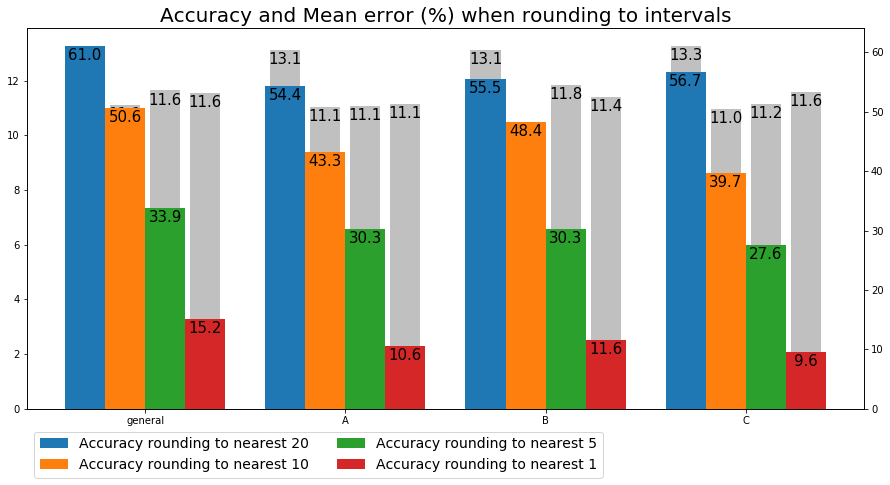

In [180]:
plot_accuracy(["sperm_data", "ss_cells", "ss_motility", "ss_pct"], ["general", "A", "B", "C"], blas_rate, [20,10,5,1])

In [12]:
def plot_accuracy_with_pca(dataset, output_labels, rounding_levels):
    fig, ax2 = plt.subplots(1,1, figsize=(15,7))
    ax = ax2.twinx()
    item = 0
    x = np.arange(2)
    width = 0.20
    width2 = 0.15
    
    def autolabel(bar, ax_name):
    #Attach a text label above each bar in *rects*, displaying its height.
        for rect in bar:
            height = rect.get_height()
            ax_name.annotate('{}'.format(round(height,1)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, -17),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize = 15)
  
    for base, loc in zip(rounding_levels, [x-1.5*width, x-0.5*width, x+0.5*width, x+1.5*width]):
        print("rounding to", base)
        blasrate_base = base * round(output_labels / base)
        acc_A, elements_A, error_A, batches_A = sandc_average_accuracy(dataset, blasrate_base, base, 20)   
        acc_B, elements_B, error_B, batches_B = sandc_average_accuracy(dataset, blasrate_base, base, 20, pca = True)
        total_acc = np.hstack((acc_A[-1], acc_B[-1]))
        total_error = np.hstack((error_A, error_B))
           
        print(total_acc)
        barErr = ax2.bar(loc, total_error, width2, color = "silver", label = "Mean Error when rounding to {}".format(base))
        barAcc = ax.bar(loc, total_acc, width, label = "Accuracy rounding to nearest {}".format(base))
        autolabel(barErr, ax2)
        autolabel(barAcc, ax)
        
    ax.set_xticks(x)
    ax.set_xticklabels(["Full dataset after processing", "PCA of dataset"], fontsize = 14)
    ax.legend(loc = 'lower left', fontsize = 14, bbox_to_anchor=(0,-0.2), ncol =2)
    ax.set_title("Accuracy and Mean error (%) when rounding to intervals", fontsize = 20)   
    plt.show()


rounding to 20


NameError: name 'output_test' is not defined

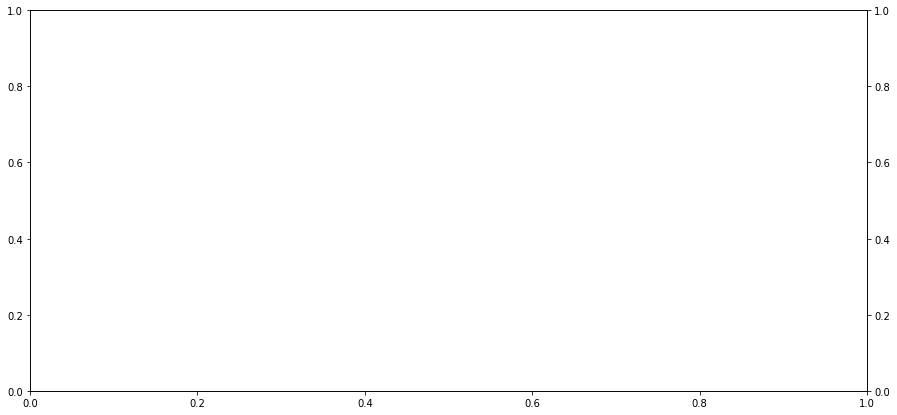

In [13]:
plot_accuracy_with_pca(sperm_data, blas_rate, [20,10,5,1])